In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram

from tracefc.io.session_directory import get_session_dir


In [2]:
# Define a class for a typical recording or set of recordings
from neuropy.core.session import ProcessData
    
def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [3]:
animal, sess_name = 'Finn2', 'training'
sess_dir = get_session_dir(animal, sess_name)
sess = sess_use(sess_dir)
print(sess.recinfo)

filename: /data3/Trace_FC/Recording_Rats/Finn2/2023_05_08_training/Finn2_training_denoised.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [4]:
print(sess.eegfile)

duration: 19024.80 seconds 
duration: 5.28 hours 



# Preprocess Ephys data
Identify artifacts:  
- disconnects  
- filtering  
  
Send to event files to check in Neuroscope  
Write `dead_times.txt` file for spyking-circus and `artifacts.npy` file for my own analysis.

### Identify disconnect and motion artifacts

In [5]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.25  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    art_epochs = detect_artifact_epochs(signal, thresh=8, 
                                    edge_cutoff=3, merge=6)

    # Code to add in artifact epochs manually - comment out after using
    # art_epochs = art_epochs.add_epoch_manually(538, 560)
    # art_epochs = art_epochs.add_epoch_manually(1588, 1615)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
art_epochs


Existing artifact epochs file loaded
Total artifact time = 45.6 seconds


17 epochs
Snippet: 
        start       stop label
0   650.5812   651.1516      
1   823.7372   824.5060      
2   854.9204   855.7524      
3   880.9212   881.6164      
4  1036.9284  1038.4908      

<Axes: >

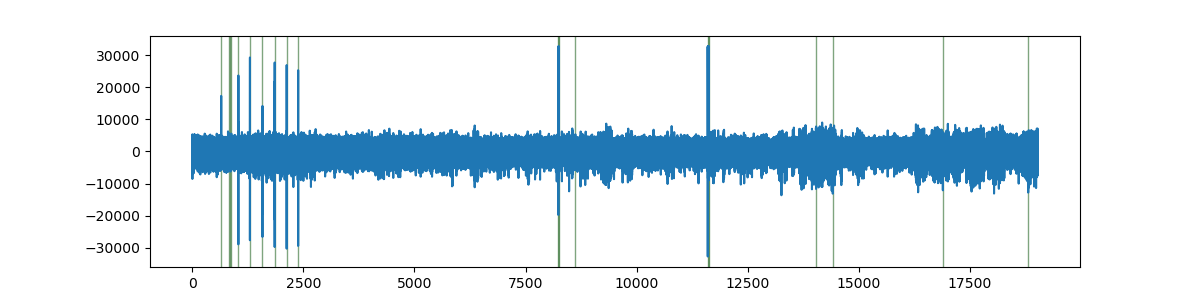

In [6]:
%matplotlib widget

chan_plot = 16
plot_signal_w_epochs(signal, chan_plot, art_epochs)

### Code below to add in epochs manually if necessary

In [7]:
# Add in epochs manually after inspection in neuroscope - then re-run above to check!
# epochs_to_add =np.array([[4.0, 6.3], [28, 30], [186.5, 187.5], [249.4, 250.25]])
# art_epochs = art_epochs.add_epoch_manually(epochs_to_add[:, 0], epochs_to_add[:, 1])
# sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
# art_epochs.save(art_epochs_file)

### Code below to import updated epochs after manual adjustment in Neuroscope!

In [8]:
# Note that Neuroscope is super buggy with adding events to existing files! One tactic is to create an .ar2 file and then add in any adjustments,
# then merge.

# art_epochs_ns = sess.recinfo.event_to_epochs(evt_file=sess.filePrefix.with_suffix('.evt.ar2'))
# art_epochs_ns

In [9]:
# Merge files and export!
# art_epochs_merge = art_epochs.__add__(art_epochs_ns).merge(0)
# art_epochs_merge.save(art_epochs_file)
# art_epochs = art_epochs_merge
# sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
# art_epochs

## Define probe group

/data3/Trace_FC/Recording_Rats/Finn2/2023_05_08_training/Finn2_training_denoised.probegroup.npy saved


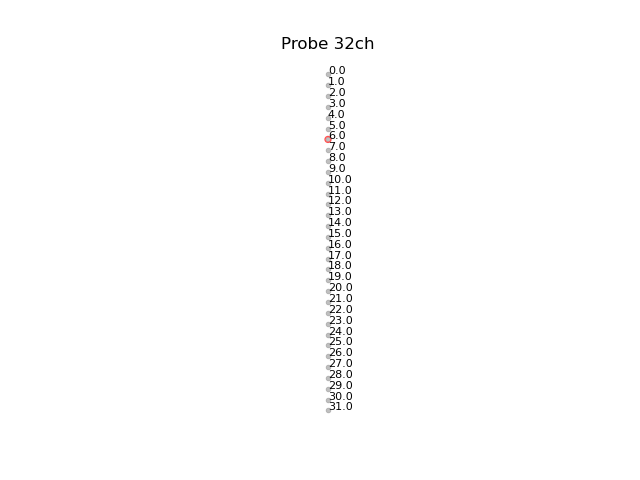

In [10]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=20, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

# Detect Theta epochs

In [11]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 5

# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
sess.recinfo.write_epochs(theta_epochs, ext='tha')

Best channel for theta: [5]
1583 epochs remaining with durations within (1,20)


## Detect SWR Epochs

In [12]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 5
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
exclude_theta_epochs = False  # make this true if you end up with a lot of false positive ripples as gamma events during theta

if not exclude_theta_epochs:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff, ignore_epochs=art_epochs)
else:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff,
                                         ignore_epochs=art_epochs.__add__(theta_epochs))
sess.recinfo.write_epochs(ripple_epochs, ext='swr')

Selected channels for ripples: [5]
14919 epochs remaining with durations within (0.05,0.45)


### Note that SWR detection is not that great for this session - cross-validate with PBEs if possible!

# Wavelet Analysis

### Start with Theta

In [13]:
# Run wavelet on theta range
theta_range = np.arange(4, 14, 0.25)  # How do I select these? 0.25Hz seems good to start
wv_theta = WaveletSg(signal.time_slice(channel_id=theta_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=theta_range, sigma=None)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

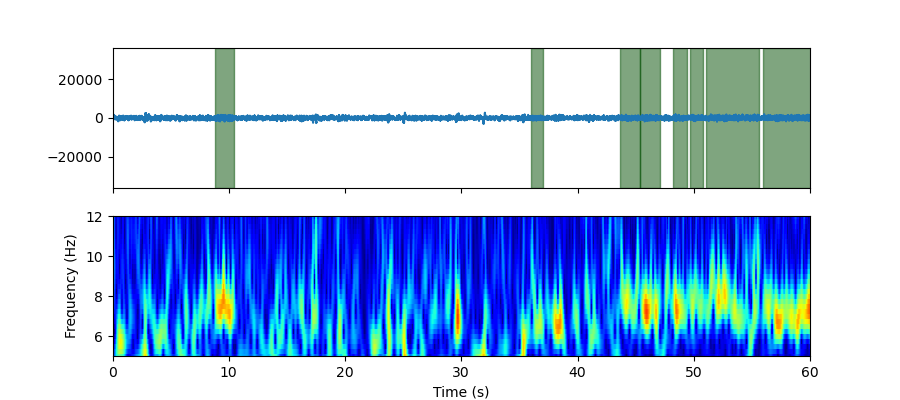

In [14]:
# Sanity check code - does wavelet align well with actual theta epochs?
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
theta_freq_lims = [5, 12]

plot_signal_w_epochs(signal, theta_channel, theta_epochs, ax=ax[0])

plot_spectrogram(wv_theta, time_lims=time_to_plot, freq_lims=theta_freq_lims, ax=ax[1])

### Mean spectrogram at theta starts

Events [ 392  393  394 ... 1580 1581 1582] are outside of data range and were dropped


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 0, 'Time from Theta epoch start (sec)')

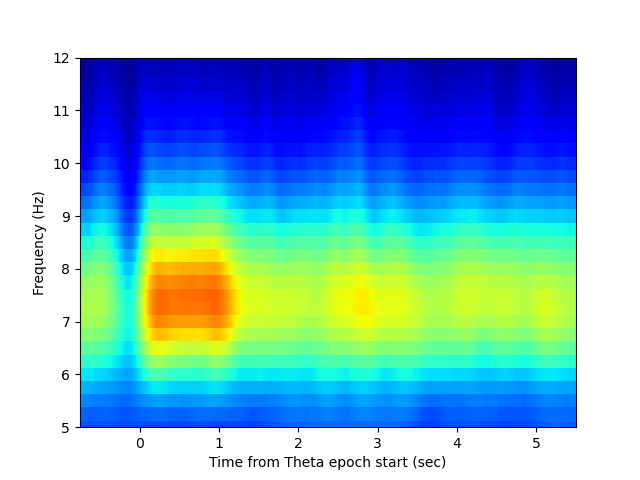

In [15]:
theta_buffer_sec = (0.75, 5.5)
wv_theta_mean = wv_theta.get_pe_mean_spec(theta_epochs.starts, buffer_sec=theta_buffer_sec)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(theta_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from Theta epoch start (sec)')

### Try out SWRs

In [19]:
swr_range = np.arange(125, 275, 5)
wv_swr = WaveletSg(signal.time_slice(channel_id=ripple_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=swr_range, sigma=None)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

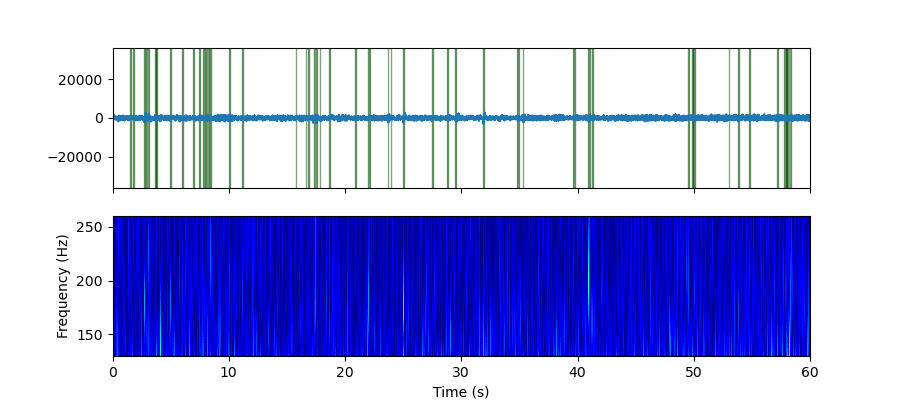

In [20]:
# Sanity check code - does wavelet align well with actual SWR epochs?
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
swr_freq_lims = [130, 260]

plot_signal_w_epochs(signal, theta_channel, ripple_epochs, ax=ax[0])

plot_spectrogram(wv_swr, time_lims=time_to_plot, freq_lims=swr_freq_lims, ax=ax[1])

### Mean spectrogram at all ripples

Events [ 3551  3552  3553 ... 14916 14917 14918] are outside of data range and were dropped


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from Ripple Peak (sec)')

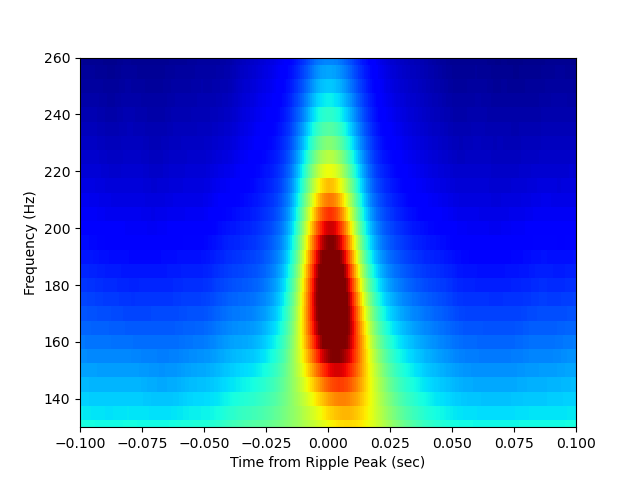

In [21]:
ripple_buffer_sec = (0.1, 0.1)
wv_swr_mean = wv_swr.get_pe_mean_spec(ripple_epochs.to_dataframe()['peak_time'].values, buffer_sec=ripple_buffer_sec)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(ripple_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from Ripple Peak (sec)')

## Peri-CS analyses

,channel_states,timestamps,datetimes,event_name
913,2,4332188,2023-05-08 11:56:34.406266667,
1062,-2,4629812,2023-05-08 11:56:44.327066667,
2102,2,6730372,2023-05-08 11:57:54.345733333,
2250,-2,7028594,2023-05-08 11:58:04.286466667,
3200,2,8946301,2023-05-08 11:59:08.210033333,


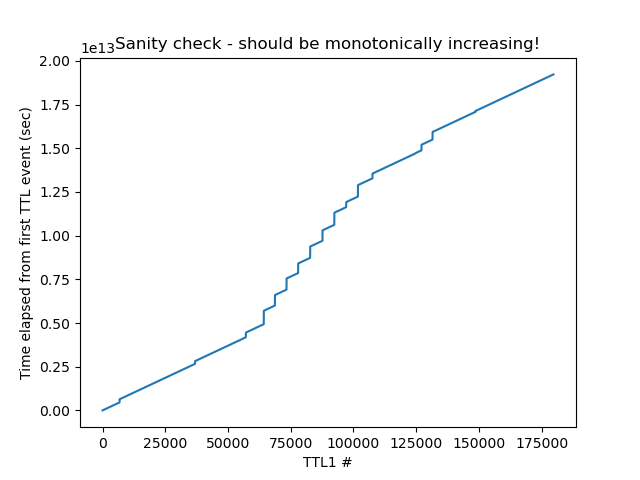

In [22]:
import neuropy.io.openephysio as oeio

# Import TTLs for CS from OpenEphys
ttl_df = oeio.load_all_ttl_events(sess.basepath, sanity_check_channel=1, zero_timestamps=True)
ttl_df[ttl_df['channel_states'].abs() == 2].head(5)

In [23]:
import tracefc.io.traceio as traceio

process_csn, process_cs, process_cs2 = True, True, True  # set flags for running code below
if sess_name.find("recall") == 0:
    # For tone recall CS+
    cs_starts, cs_ends, cs_df = traceio.load_trace_events(sess.basepath, session_type="tone_recall", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs_starts.shape[0]} CS+ events detected during {sess_name} tone recall')
    print(cs_starts.head(6))
    
    # For control tone recall CS-
    csn_starts, csn_ends, csn_df = traceio.load_trace_events(sess.basepath, session_type="control_tone_recall", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected during {sess_name} control tone recall')
    print(csn_starts.head(6))
    
    # For CS+ at end of control_tone_recall
    cs2_starts, cs2_ends, cs2_df = traceio.load_trace_events(sess.basepath, session_type="control_tone_recall", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs2_starts.shape[0]} CS+ events detected during {sess_name} control tone recall')
    print(cs2_starts.head(6))
elif sess_name.find("habituation") == 0:
    # For control tone habituation CS-
    csn_starts, csn_ends, csn_df = traceio.load_trace_events(sess.basepath, session_type="tone_habituation", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected during {sess_name} tone habituation')
    print(csn_starts.head(6))

    process_cs, process_cs2 = False, False
    
elif sess_name.find("training") == 0:
    # For control tone habituation CS-
    csn_starts, csn_ends, csn_df = traceio.load_trace_events(sess.basepath, session_type="tone_habituation", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected during {sess_name} tone habituation')
    print(csn_starts.head(6))

    # For training CS+
    cs_starts, cs_ends, cs_df = traceio.load_trace_events(sess.basepath, session_type="training", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs_starts.shape[0]} CS+ events detected during {sess_name} training')
    print(cs_starts.head(6))

    process_cs2 = False
    

5 CS- events detected during training tone habituation
      Time (s)      Event                     Timestamp
5    61.580098  CS1_start 2023-05-08 11:56:34.516826675
7   141.519549  CS2_start 2023-05-08 11:57:54.456278131
9   215.384520  CS3_start 2023-05-08 11:59:08.321249054
11  278.086569  CS4_start 2023-05-08 12:00:11.023298309
13  358.010654  CS5_start 2023-05-08 12:01:30.947383211
6 CS+ events detected during training training
       Time (s)      Event                     Timestamp
6    365.882155  CS1_start 2023-05-08 12:12:14.912075418
16   625.563774  CS2_start 2023-05-08 12:16:34.593693870
26   907.587123  CS3_start 2023-05-08 12:21:16.617043156
36  1182.504313  CS4_start 2023-05-08 12:25:51.534232992
46  1452.332576  CS5_start 2023-05-08 12:30:21.362496036
56  1711.011817  CS6_start 2023-05-08 12:34:40.041737217


In [24]:
sync_df = oeio.create_sync_df(sess.basepath)
sync_df

start time = 2023-05-08 11:54:10-04:00
start time = 2023-05-08 12:04:32-04:00
start time = 2023-05-08 12:41:12-04:00
start time = 2023-05-08 14:15:17-04:00
start time = 2023-05-08 15:12:40-04:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time
0,0,2023-05-08 11:54:10-04:00,start,0,0.000000,0,0.0000
1,0,2023-05-08 12:03:14.375433333-04:00,stop,16331263,544.375433,680469,544.3752
2,1,2023-05-08 12:04:32-04:00,start,16331264,544.375467,680470,544.3760
3,1,2023-05-08 12:40:06.536500-04:00,stop,80367359,2678.911967,3348639,2678.9112
4,2,2023-05-08 12:41:12-04:00,start,80367360,2678.912000,3348640,2678.9120
5,2,2023-05-08 14:13:58.532233333-04:00,stop,247363327,8245.444233,10306805,8245.4440
6,3,2023-05-08 14:15:17-04:00,start,247363328,8245.444267,10306806,8245.4448
7,3,2023-05-08 15:11:31.677300-04:00,stop,348603647,11620.121567,14525151,11620.1208
8,4,2023-05-08 15:12:40-04:00,start,348603648,11620.121600,14525152,11620.1216
9,4,2023-05-08 17:16:04.680500-04:00,stop,570744063,19024.802100,23781002,19024.8016


In [25]:
# Grab CS times corresponding to OE timestamps
ttl_lag_use = ttl_lag=pd.Timedelta(0.8, unit="seconds")

# CS+
if process_cs:
    cs_oe_start_df = traceio.trace_ttl_to_openephys(cs_starts, 
                                      ttl_df[ttl_df['channel_states'].abs() == 2], 
                                      ttl_lag=ttl_lag_use)
    # Convert to times in combined eeg file
    cs_starts_combined = oeio.recording_events_to_combined_time(cs_oe_start_df, sync_df)

# CS-
csn_oe_start_df = traceio.trace_ttl_to_openephys(csn_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2)

# Convert to times in combined eeg file
csn_starts_combined = oeio.recording_events_to_combined_time(csn_oe_start_df, sync_df)

# CS+ 2
if process_cs2:
    cs2_oe_start_df = traceio.trace_ttl_to_openephys(cs2_starts, 
                                      ttl_df[ttl_df['channel_states'].abs() == 2], 
                                      ttl_lag=ttl_lag_use)
    # Convert to times in combined eeg file
    cs2_starts_combined = oeio.recording_events_to_combined_time(cs2_oe_start_df, sync_df)

start time lag: mean = -0.40930200366666664, std = 0.0012269775854382478
start time lag: mean = -0.1110670762, std = 0.000495073273146712


## Theta mean spectrogram

1953 frames between 1036.9 and 1038.5 ignored (sent to nan)
2290 frames between 1296.6 and 1298.5 ignored (sent to nan)
1982 frames between 1578.6 and 1580.2 ignored (sent to nan)
1902 frames between 1853.5 and 1855.1 ignored (sent to nan)
1971 frames between 2123.4 and 2125.0 ignored (sent to nan)
1961 frames between 2382.1 and 2383.6 ignored (sent to nan)


/data/GitHub/NeuroPy/neuropy/utils/signal_process.py:169: RuntimeWarning: Mean of empty slice
  sxx_mean = np.nanmean(np.stack(sxx_list, axis=2), axis=2)


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

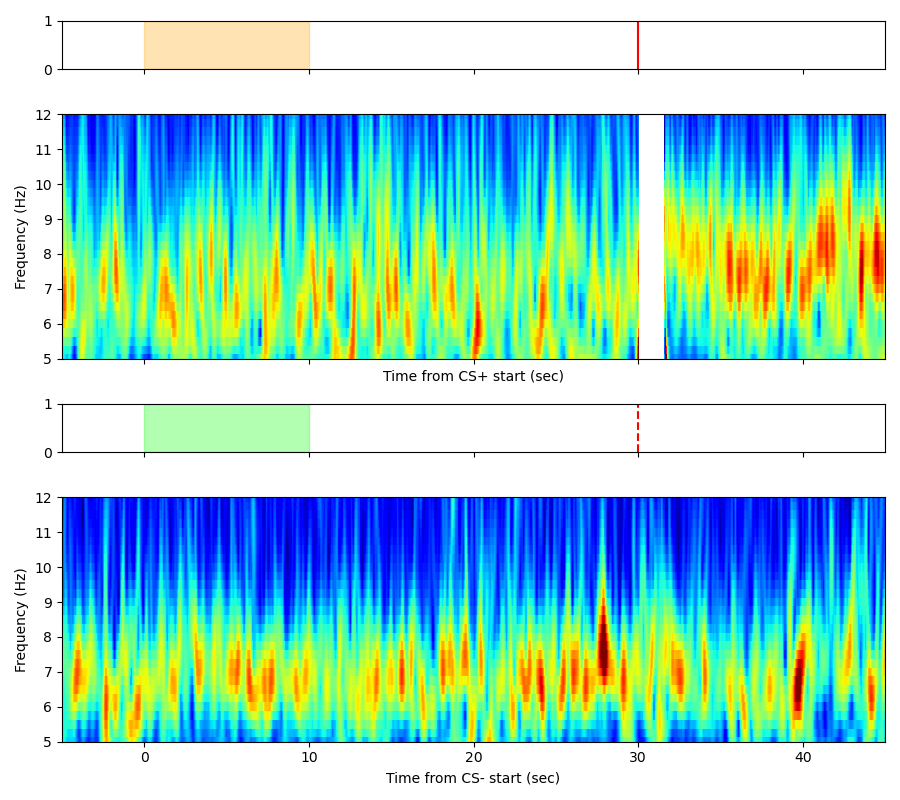

In [40]:
from tracefc.plotting.signals import plot_cs_mean_wavelet
cs_buffer = (5, 45)

# For recall sessions
if sess_name.find("recall") == 0:
    _, ax = plt.subplots(6, 1, figsize=(9, 12), height_ratios=[1, 5, 1, 5, 1, 5], layout='tight', sharex=True)
    _, std_sxx = plot_cs_mean_wavelet(wv_theta, cs_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                         ignore_epochs=art_epochs, ax=ax[:2])
    plot_cs_mean_wavelet(wv_theta, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[2:4])
    plot_cs_mean_wavelet(wv_theta, cs2_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[4:])
    ax[5].set_title('CS+ at end of control tone recall session')

if sess_name.find("training") == 0: # for training sessions
    _, ax = plt.subplots(4, 1, figsize=(9, 8), height_ratios=[1, 5, 1, 5], layout='tight', sharex=True)
    _, std_sxx = plot_cs_mean_wavelet(wv_theta, cs_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                         ignore_epochs=art_epochs, ax=ax[:2])
    plot_cs_mean_wavelet(wv_theta, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[2:4])

    # Change red line to solid
    line_ind = np.where([isinstance(a, plt.Line2D) for a in ax[0].get_children()])[0][0]
    ax[0].get_children()[line_ind].set_linestyle('-')
    
elif sess_name.find("habituation") == 0: # For habituation sessions
    _, ax = plt.subplots(2, 1, figsize=(9, 4), height_ratios=[1, 5], layout='tight', sharex=True)

    plot_cs_mean_wavelet(wv_theta, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=None, ax=ax[:2])

## Ripple mean spectrogram

1953 frames between 1036.9 and 1038.5 ignored (sent to nan)
2290 frames between 1296.6 and 1298.5 ignored (sent to nan)
1982 frames between 1578.6 and 1580.2 ignored (sent to nan)
1903 frames between 1853.5 and 1855.1 ignored (sent to nan)
1971 frames between 2123.4 and 2125.0 ignored (sent to nan)
1961 frames between 2382.1 and 2383.6 ignored (sent to nan)


/data/GitHub/NeuroPy/neuropy/utils/signal_process.py:169: RuntimeWarning: Mean of empty slice
  sxx_mean = np.nanmean(np.stack(sxx_list, axis=2), axis=2)


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

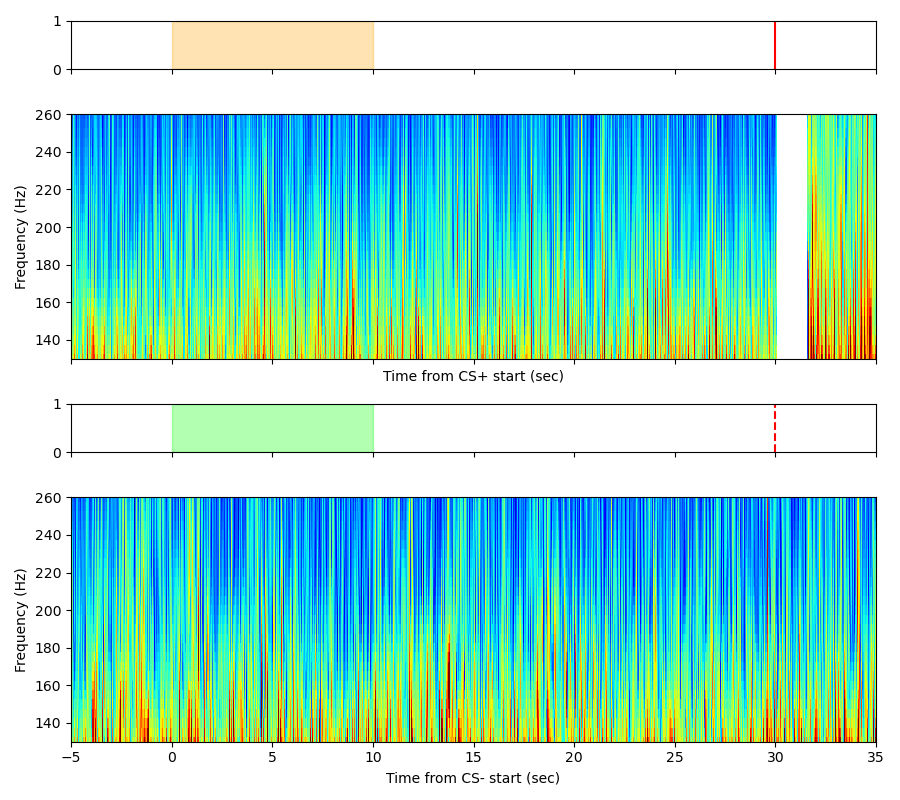

In [41]:
cs_buffer = (5, 35)

# For recall sessions
if sess_name.find("recall") == 0:
    _, ax = plt.subplots(6, 1, figsize=(9, 12), height_ratios=[1, 5, 1, 5, 1, 5], layout='tight', sharex=True)
    
    _, std_sxx = plot_cs_mean_wavelet(wv_swr, cs_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
                         ignore_epochs=art_epochs, ax=ax[:2])
    plot_cs_mean_wavelet(wv_swr, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[2:4])
    plot_cs_mean_wavelet(wv_swr, cs2_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[4:])
    ax[5].set_title('CS+ at end of control tone recall session')

elif sess_name.find("training") == 0:
    _, ax = plt.subplots(4, 1, figsize=(9, 8), height_ratios=[1, 5, 1, 5], layout='tight', sharex=True)
    
    _, std_sxx = plot_cs_mean_wavelet(wv_swr, cs_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
                         ignore_epochs=art_epochs, ax=ax[:2])
    plot_cs_mean_wavelet(wv_swr, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[2:4])
    # Change red line to solid
    line_ind = np.where([isinstance(a, plt.Line2D) for a in ax[0].get_children()])[0][0]
    ax[0].get_children()[line_ind].set_linestyle('-')
    
elif sess_name.find("habituation") == 0: # For habituation sessions
    _, ax = plt.subplots(2, 1, figsize=(9, 8), height_ratios=[1, 5], layout='tight', sharex=True)
    plot_cs_mean_wavelet(wv_swr, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=None, ax=ax[:2])

## Save notebook to working directory

In [42]:
from neuropy.utils.manipulate_files import save_notebook
save_notebook(sess.basepath, save_prepend=f"{animal}_{sess_name}_")

/data/GitHub/TraceFC/Notebooks/Spectral_Analysis.ipynb saved to /data3/Trace_FC/Recording_Rats/Finn2/2023_05_08_training/Finn2_training_Spectral_Analysis.ipynb
